# 8a.nu datascience project
## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from pprint import pprint
from scipy.stats.mstats import gmean
import datetime
%matplotlib inline

## Database stuff

In [2]:
conn   = sqlite3.connect("../database.sqlite")
cursor = conn.cursor()

## Load user data

In [3]:
dfl_user = []
df_user = pd.DataFrame()

query = "SELECT * FROM user"

for chunk in pd.read_sql(query, conn, chunksize=10000):
    dfl_user.append(chunk)
df_user = pd.concat(dfl_user, ignore_index=True)


## Load grades

In [4]:
dfl_grades = []
df_grades = pd.DataFrame()

query = "SELECT * FROM grade"
for chunk in pd.read_sql(query, conn, chunksize=10000):
    dfl_grades.append(chunk)
df_grades = pd.concat(dfl_grades, ignore_index=True)

## Load ascents

In [5]:
dfl_ascents = []
df_ascents = pd.DataFrame()

query = "SELECT * FROM ascent WHERE climb_type=1 AND total_score>0" #climb_type=1 -> bouldering
for chunk in pd.read_sql(query, conn, chunksize=1000):
    dfl_ascents.append(chunk)

df_ascents = pd.concat(dfl_ascents, ignore_index=True)

## Add column where date timestamp is converted to a year

In [6]:
df_ascents["year_climbed"] = df_ascents["date"].apply(lambda x: datetime.date.fromtimestamp(x).year)

## Find the year where each user started climbing and the year of the first logbook entry

In [7]:
startYears = df_user[["id", "started"]]
startYears = startYears[startYears["started"]!=0]
firstLoggedYears = pd.DataFrame(df_ascents.groupby("user_id")[["year_climbed"]].min()["year_climbed"]).rename(columns={"year_climbed": "first_log"})

## Create new Dataframe to calculate how many years after the start a climb has been logged

In [13]:
df_years = pd.merge(startYears.set_index("id"), firstLoggedYears, left_index=True, right_index=True)
df_years["first_log_years_after_start"] = df_years["first_log"] - df_years["started"]
df_years = df_years[(df_years["first_log_years_after_start"]>=0)]
print(df_years)

       started  first_log  first_log_years_after_start
1         1996       2002                            6
2         2000       2000                            0
3         1995       1999                            4
4         2001       2006                            5
5         1991       1996                            5
...        ...        ...                          ...
66968     2013       2014                            1
66980     2013       2017                            4
66996     2009       2017                            8
66999     2015       2017                            2
67022     2016       2017                            1

[13859 rows x 3 columns]


## Filter the ascents to only include users that specified the year they started climbing
## Remove entries before 1970

In [16]:
filtered_ascents = df_ascents[df_ascents["user_id"].isin(df_years.index)]

filtered_ascents = filtered_ascents.assign(start_year=filtered_ascents.user_id.map(startYears.set_index("id").started))
filtered_ascents = filtered_ascents[filtered_ascents["start_year"]>1970]
filtered_ascents["years_since_start"] = filtered_ascents["year_climbed"] - filtered_ascents["start_year"]

filtered_ascents.sort_values(["user_id", "year"]).head(10)


,id,user_id,grade_id,notes,raw_notes,method_id,climb_type,total_score,date,year,...,description,yellow_id,climb_try,repeat,exclude_from_ranking,user_recommended,chipped,year_climbed,start_year,years_since_start
9434,37265,1,44,,0,1,1,600,1010098800,2002,...,,255,0,0,0,0,0,2002,1996,6
9435,37266,1,44,,0,1,1,600,1010098800,2002,...,,255,0,0,0,0,0,2002,1996,6
11808,44846,1,44,,0,1,1,600,1017529200,2002,...,,255,0,0,0,0,0,2002,1996,6
11809,44847,1,38,,0,5,1,545,1017529200,2002,...,,0,0,0,0,0,0,2002,1996,6
11868,45010,1,36,,0,1,1,400,1017612000,2002,...,,255,0,0,0,0,0,2002,1996,6
11869,45011,1,40,,0,1,1,500,1018908000,2002,...,,255,0,0,0,0,0,2002,1996,6
12164,46046,1,36,,0,1,1,400,1017871200,2002,...,,0,0,0,0,0,0,2002,1996,6
12765,47941,1,31,,0,1,1,300,1018476000,2002,...,,0,0,0,0,0,0,2002,1996,6
12766,47942,1,21,,0,1,1,200,1018476000,2002,...,,0,0,0,0,0,0,2002,1996,6
12767,47943,1,21,,0,1,1,200,1010703600,2002,...,,0,0,0,0,0,0,2002,1996,6


## Calculate the average of the three hardest climbs for each year as a measure of progession

In [17]:
max3avg = filtered_ascents.groupby(["user_id", "year_climbed", "start_year", "years_since_start"], as_index=False)["grade_id"].mean().rename(columns={"grade_id": "max3avg"})

## Remove users that haven't logged for more than 3 years

In [18]:
max3avg = max3avg.groupby(["user_id"]).filter(lambda x: len(x)>3)
max3avg.sort_values(["user_id", "year_climbed"]).head(10)

,user_id,year_climbed,start_year,years_since_start,max3avg
0,1,2002,1996,6,32.825000
1,1,2003,1996,7,45.666667
2,1,2004,1996,8,45.666667
3,1,2005,1996,9,47.800000
9,5,1996,1991,5,42.000000
10,5,1997,1991,6,42.000000
11,5,1998,1991,7,42.666667
12,5,1999,1991,8,49.333333
13,5,2000,1991,9,46.941176
14,5,2001,1991,10,47.297872


## Create plot

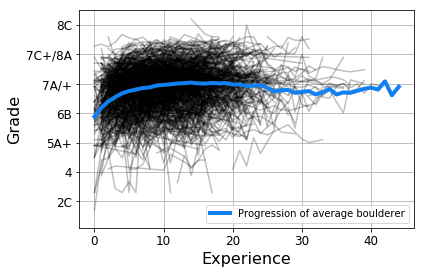

In [19]:
fig, ax = plt.subplots()
ax.grid()
userIds = max3avg["user_id"].unique().tolist()[:1000]
for uid in userIds:
    ax.plot(max3avg[max3avg["user_id"]==uid]["years_since_start"], 
            max3avg[max3avg["user_id"]==uid]["max3avg"], 
            "-k", alpha=0.25, label='_nolegend_')

meanGrade = max3avg.groupby(["years_since_start"])["max3avg"].mean()
ax.plot(meanGrade.index, 
        meanGrade, 
        color="#1180f0", 
        linewidth=4,
        label="Progression of average boulderer")

ax.set_ylim(1,75)
plt.draw()

## Use the FB-grades as y-ticks
ticks = ax.get_yticklabels()
grades_fb = df_grades[["id", "fra_boulders"]]

grade_ids = [int(float(tick.get_text())) for tick in ticks if tick.get_text() != ""]
## tick labels don't necessarily match grade_id
## therefore, find the closest grade_id to a given tick label
grade_ids_processed = [min(grades_fb["id"], key=lambda x:abs(x-grade_id)) for grade_id in grade_ids]
grade_ticks = grades_fb[grades_fb["id"].isin(grade_ids_processed)]["fra_boulders"].tolist()
grade_ticks = [""] + grade_ticks + [""]

ax.set_yticklabels(grade_ticks)

ax.tick_params(labelsize=12)
ax.set_xlabel("Experience", fontsize=16)
ax.set_ylabel("Grade", fontsize=16)

ax.legend()